# MULTIMODAL DATASET CREATION

In [1]:
import os
import pandas as pd
import requests
from datetime import datetime

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [2]:
def get_midpoint_from_csv(csv_path):
    """Compute midpoint timestamp from MVTS instance file."""
    df = pd.read_csv(csv_path, sep="\t")
    df = df.iloc[:, :25]
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    start, end = df['Timestamp'].iloc[0], df['Timestamp'].iloc[-1]
    mid = start + (end - start) / 2
    return mid

def fetch_sdo_image(midpoint_dt, source_id, output_filename):
    """Fetch closest SDO image (JP2) from Helioviewer."""
    date_str = midpoint_dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    url_img = "https://api.helioviewer.org/v2/getJP2Image/"
    resp = requests.get(url_img, params={"date": date_str, "sourceId": source_id})
    if resp.status_code == 200:
        with open(output_filename, "wb") as f:
            f.write(resp.content)
        return True
    else:
        print(f"[WARN] Could not fetch image for {date_str}")
        return False


In [17]:
def process_partition(partition):
    in_dir = os.path.join(BASE_INPUT, partition)
    out_dir = os.path.join(BASE_OUTPUT, partition)

    # for label in ["FL", "NF"]:
    for label in ["FL"]:
        in_sub = os.path.join(in_dir, label)
        out_sub = os.path.join(out_dir, label)
        ensure_dir(out_sub)

        # Gather candidate CSVs
        csv_files = [f for f in os.listdir(in_sub) if f.endswith(".csv")]

        # If NF → reduce to unique ARs (latest only)
        if label == "NF":
            ar_latest = {}
            for file in csv_files:
                csv_path = os.path.join(in_sub, file)
                # Parse AR number from filename (assuming format has AR####)
                ar_num = None
                for token in file.split("_"):
                    if token.startswith("ar"):
                        ar_num = token
                        break
                if ar_num is None:
                    continue
                # Use file timestamp for recency
                mtime = os.path.getmtime(csv_path)
                if ar_num not in ar_latest or mtime > ar_latest[ar_num][0]:
                    ar_latest[ar_num] = (mtime, file)
            csv_files = [v[1] for v in ar_latest.values()]

        # Process chosen files
        for file in csv_files:
            csv_path = os.path.join(in_sub, file)
            out_csv = os.path.join(out_sub, file)
            base_out = os.path.splitext(out_csv)[0]

            # Copy CSV if not already
            if not os.path.exists(out_csv):
                os.system(f"cp '{csv_path}' '{out_csv}'")

            # Midpoint timestamp
            mid = get_midpoint_from_csv(csv_path)

            # Fetch both images
            fetch_sdo_image(mid, source_id=14, output_filename=base_out + "_AIA.jp2")  # AIA 171Å
            fetch_sdo_image(mid, source_id=19, output_filename=base_out + "_HMI.jp2")  # HMI Vector Mag

In [18]:
def build_multimodal_dataset():
    for p in [f"partition{i}" for i in range(1, 6)]:
        process_partition(p)

In [19]:
BASE_INPUT = "../../DATA/SWAN-SF"
BASE_OUTPUT = "../../DATA/SWAN-SF_IMG"

In [10]:
process_partition("partition1")

In [12]:
process_partition("partition2")

/var/folders/dp/02hnddtd2fz814xh8tsv1rhm0000gn/T/ipykernel_17379/2047261765.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])
/var/folders/dp/02hnddtd2fz814xh8tsv1rhm0000gn/T/ipykernel_17379/2047261765.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])
/var/folders/dp/02hnddtd2fz814xh8tsv1rhm0000gn/T/ipykernel_17379/2047261765.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])
/var/folders/dp/02hnddtd2fz814xh8tsv1rhm0000gn

In [13]:
process_partition("partition3")

In [20]:
process_partition("partition4")

In [14]:
process_partition("partition5")

In [22]:
import os

BASE_OUTPUT = "../../DATA/SWAN-SF_IMG"  # where CSV + images are stored

def report_partition_summary():
    summary = []

    for p in [f"partition{i}" for i in range(1, 6)]:
        part_dir = os.path.join(BASE_OUTPUT, p)
        if not os.path.exists(part_dir):
            print(f"[WARN] Missing {part_dir}")
            continue

        for label in ["FL", "NF"]:
            subdir = os.path.join(part_dir, label)
            if not os.path.exists(subdir):
                print(f"[WARN] Missing {subdir}")
                continue

            # Count files
            csv_count = len([f for f in os.listdir(subdir) if f.endswith(".csv")])
            aia_count = len([f for f in os.listdir(subdir) if f.endswith("_AIA.jp2")])
            hmi_count = len([f for f in os.listdir(subdir) if f.endswith("_HMI.jp2")])

            summary.append({
                "Partition": p,
                "Label": label,
                "TimeSeries (CSV)": csv_count,
                "AIA Images": aia_count,
                "HMI Images": hmi_count
            })

    # Pretty print
    import pandas as pd
    df = pd.DataFrame(summary)
    print(df.to_string(index=False))
    return df

# Run
report_partition_summary()


 Partition Label  TimeSeries (CSV)  AIA Images  HMI Images
partition1    FL              1254        1254        1254
partition1    NF               699         699         699
partition2    FL              1401        1401        1401
partition2    NF               885         885         885
partition3    FL              1424        1424        1424
partition3    NF               390         390         390
partition4    FL              1165        1165        1165
partition4    NF               472         472         472
partition5    FL               990         990         990
partition5    NF               758         758         758


,Partition,Label,TimeSeries (CSV),AIA Images,HMI Images
0,partition1,FL,1254,1254,1254
1,partition1,NF,699,699,699
2,partition2,FL,1401,1401,1401
3,partition2,NF,885,885,885
4,partition3,FL,1424,1424,1424
5,partition3,NF,390,390,390
6,partition4,FL,1165,1165,1165
7,partition4,NF,472,472,472
8,partition5,FL,990,990,990
9,partition5,NF,758,758,758


Visualizing FQ_ar1320_s2012-01-15T06:24:00_e2012-01-15T18:12:00.csv


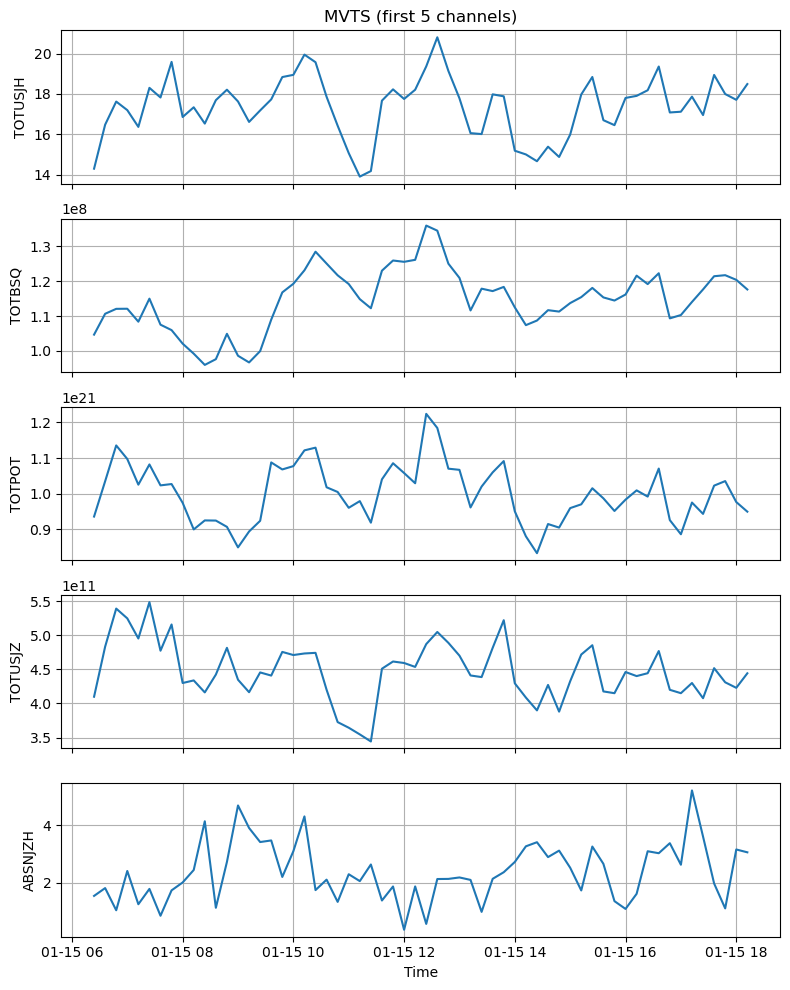

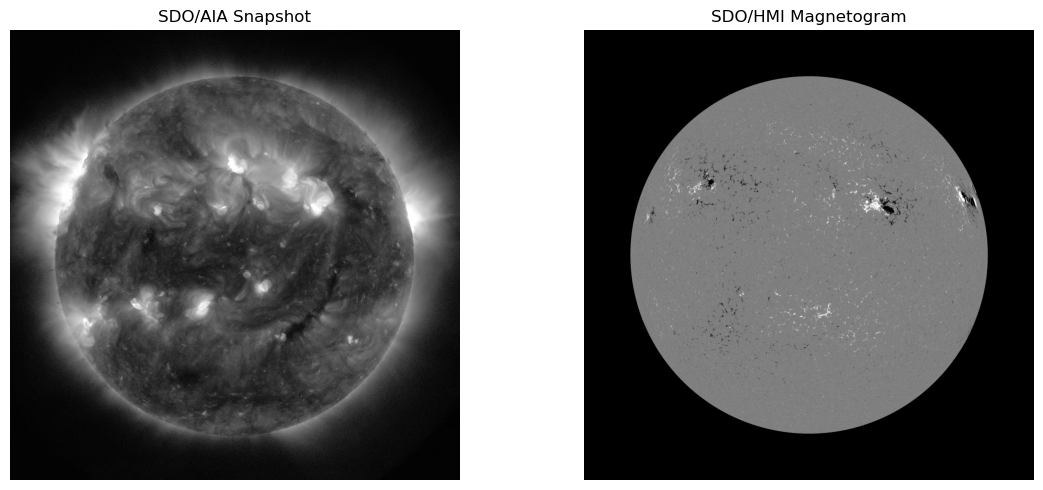

In [25]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

BASE_OUTPUT = "../../DATA/SWAN-SF_IMG"

def visualize_random_example(partition="partition1", label="NF"):
    subdir = os.path.join(BASE_OUTPUT, partition, label)
    files = [f for f in os.listdir(subdir) if f.endswith(".csv")]
    if not files:
        print(f"No CSV files found in {subdir}")
        return
    
    # Pick one random file
    csv_file = random.choice(files)
    base_name = os.path.splitext(csv_file)[0]
    csv_path = os.path.join(subdir, csv_file)
    aia_path = os.path.join(subdir, base_name + "_aia.jp2")
    hmi_path = os.path.join(subdir, base_name + "_hmi.jp2")

    print(f"Visualizing {csv_file}")

    # --- Load MVTS ---
    df = pd.read_csv(csv_path, sep="\t")
    if "Timestamp" in df.columns:
        df["Timestamp"] = pd.to_datetime(df["Timestamp"])
        time = df["Timestamp"]
        signals = df.drop(columns=["Timestamp"])
    else:
        time = range(len(df))
        signals = df

    # Limit number of channels to visualize (optional)
    max_channels = 5
    signals = signals.iloc[:, :max_channels]

    # --- Plot MVTS with separate subplots ---
    fig_ts, axes_ts = plt.subplots(max_channels, 1, figsize=(8, 2 * max_channels), sharex=True)
    for i, col in enumerate(signals.columns):
        axes_ts[i].plot(time, signals[col])
        axes_ts[i].set_ylabel(col)
        axes_ts[i].grid(True)
    axes_ts[0].set_title("MVTS (first {} channels)".format(max_channels))
    axes_ts[-1].set_xlabel("Time")
    plt.tight_layout()
    plt.show()

    # --- Plot AIA and HMI images side by side ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # AIA
    if os.path.exists(aia_path):
        img_aia = mpimg.imread(aia_path)
        axes[0].imshow(img_aia, cmap="gray")
        axes[0].set_title("SDO/AIA Snapshot")
        axes[0].axis("off")
    else:
        axes[0].set_title("AIA missing")
        axes[0].axis("off")

    # HMI
    if os.path.exists(hmi_path):
        img_hmi = mpimg.imread(hmi_path)
        axes[1].imshow(img_hmi, cmap="gray")
        axes[1].set_title("SDO/HMI Magnetogram")
        axes[1].axis("off")
    else:
        axes[1].set_title("HMI missing")
        axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Example run
visualize_random_example(partition="partition1", label="NF")



Visualizing M2.0@3087:Primary_ar1256_s2011-12-29T04:24:00_e2011-12-29T16:12:00.csv


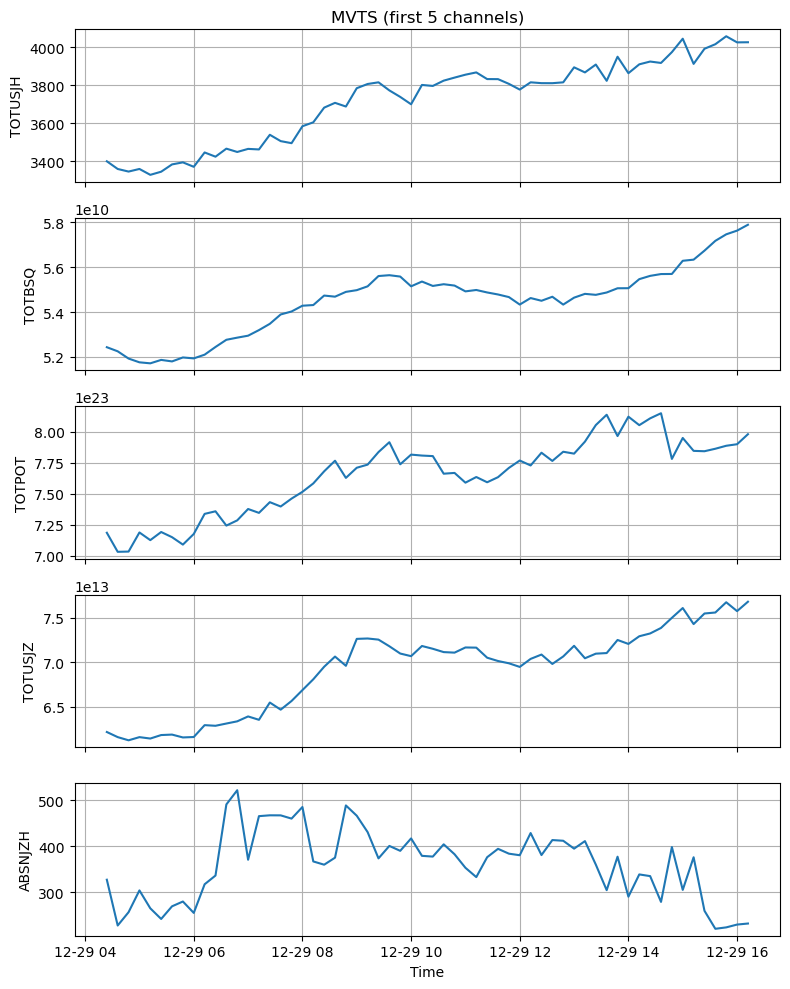

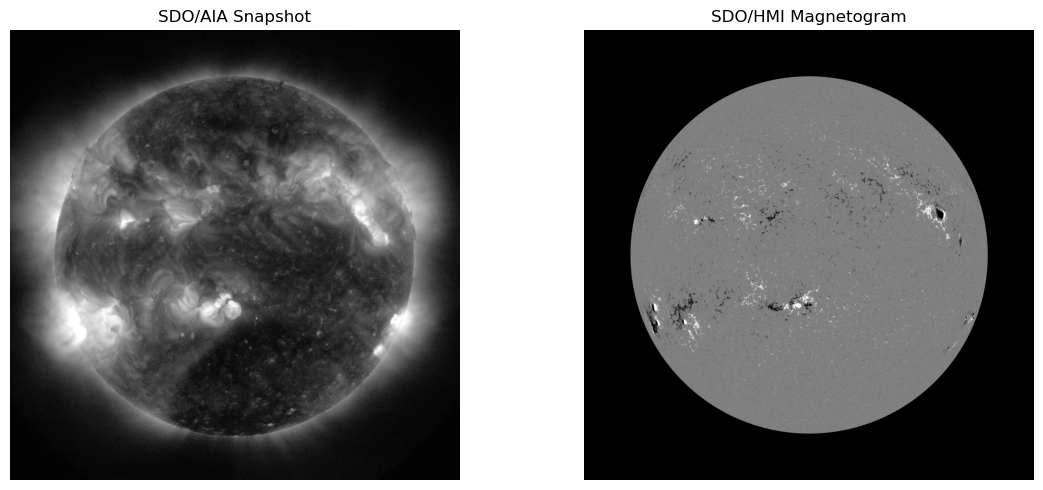

In [26]:
visualize_random_example(partition="partition1", label="FL")